# Quantization-aware training of Wav2Vec2 on CPU


Before we start, let's install both `datasets`,  `transformers` and `librosa`.

In [1]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install librosa

In [2]:
device = 'cpu'

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

Let's start by loading the dataset and taking a look at its structure.

In [3]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [5]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [6]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [7]:
timit = timit.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [8]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [9]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [10]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [11]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'w': 0,
 'c': 1,
 'v': 2,
 'b': 3,
 'p': 4,
 't': 5,
 'j': 6,
 'r': 7,
 's': 8,
 'x': 9,
 'h': 10,
 'u': 11,
 'z': 12,
 'a': 13,
 "'": 14,
 'y': 15,
 'q': 16,
 'o': 17,
 'd': 18,
 'k': 19,
 'i': 20,
 'n': 21,
 'g': 22,
 'e': 23,
 'l': 24,
 'f': 25,
 ' ': 26,
 'm': 27}

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [12]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [13]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

Let's now save the vocabulary as a json file.

In [14]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [15]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [16]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [17]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset.

Let's apply the data preparation function to all examples.

In [18]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [19]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [20]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

Now we are ready to start training!

## Quantization-Aware Training

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

In [21]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [22]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [23]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

In [24]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [25]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

model_quantized = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_q.bias', 'project_hid.bias', 'project_hid.weight', 'quantizer.codevectors', 'project_q.weight']
- This IS expected if you are initia

In [26]:
 model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [27]:
model_quantized.wav2vec2.encoder.layers = torch.quantization.quantize_dynamic(
    model.wav2vec2.encoder.layers,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)

model_quantized.wav2vec2.feature_extractor.conv_layers = torch.quantization.quantize_dynamic(
    model_quantized.wav2vec2.feature_extractor.conv_layers,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)

model_quantized.wav2vec2.feature_projection = torch.quantization.quantize_dynamic(
    model_quantized.wav2vec2.feature_projection,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)


model_quantized.wav2vec2.encoder.layer_norm = torch.quantization.quantize_dynamic(
    model_quantized.wav2vec2.encoder.layer_norm,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)

model_quantized.wav2vec2.encoder.layers = torch.quantization.quantize_dynamic(
    model_quantized.wav2vec2.encoder.layers,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)

model_quantized.lm_head = torch.quantization.quantize_dynamic(
    model_quantized.lm_head,
    {torch.nn.Linear, torch.nn.Conv1d},
    dtype=torch.qint8
).to(device)

model_quantized = model_quantized.to(device)

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [28]:
model.freeze_feature_encoder()

In [29]:
model_quantized.freeze_feature_encoder()

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="wav2vec2-base-timit-demo-google-colab",
  group_by_length=True,
  per_device_train_batch_size=128,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=False,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [31]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

In [32]:
trainer_quantized = Trainer(
    model=model_quantized,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

### Training

In [33]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 1
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 32
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=32, training_loss=8.640066146850586, metrics={'train_runtime': 10267.232, 'train_samples_per_second': 0.387, 'train_steps_per_second': 0.003, 'total_flos': 1.0879110671022144e+17, 'train_loss': 8.640066146850586, 'epoch': 1.0})

In [34]:
trainer_quantized.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 1
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=32, training_loss=8.950430870056152, metrics={'train_runtime': 5773.8278, 'train_samples_per_second': 0.689, 'train_steps_per_second': 0.006, 'total_flos': 1.035372153606912e+16, 'train_loss': 8.950430870056152, 'epoch': 1.0})

### Base vs Quantized Model visualisation

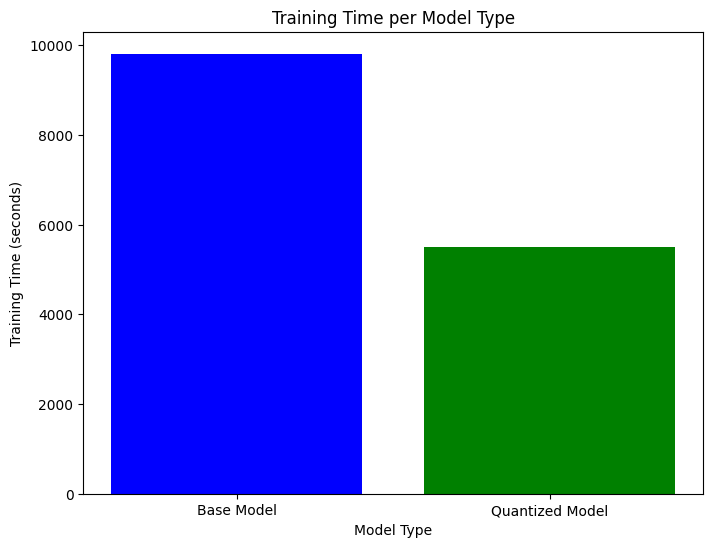

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['Base Model', 'Quantized Model'],
    'Training Time (s)': [
        2 * 3600 + 43 * 60 + 29,
        1 * 3600 + 31 * 60 + 49
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
plt.bar(df['Model'], df['Training Time (s)'], color=['blue', 'green'])
plt.xlabel('Model Type')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Model Type')
plt.show()


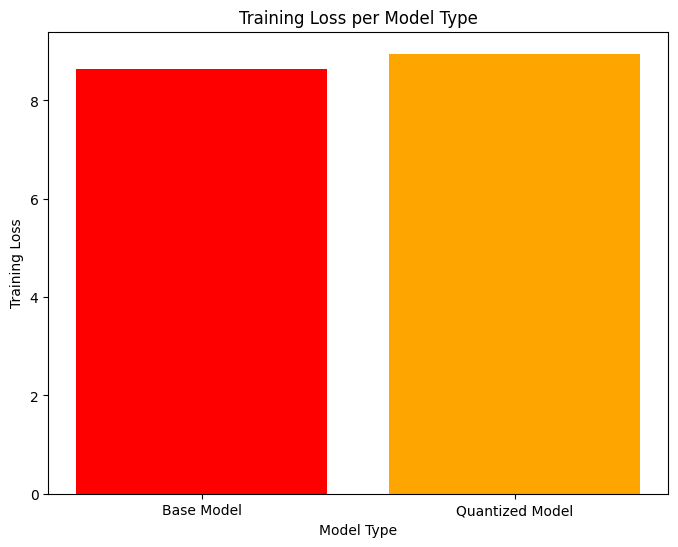

In [2]:
data = {
    'Model': ['Base Model', 'Quantized Model'],
    'Training Loss': [
        8.640066146850586,
        8.950430870056152
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
plt.bar(df['Model'], df['Training Loss'], color=['red', 'orange'])
plt.xlabel('Model Type')
plt.ylabel('Training Loss')
plt.title('Training Loss per Model Type')
plt.show()
